# Phase 1: Data Loading and Preprocessing

## Step 1: Load Dataset from Parquet File

- We begin by loading the network intrusion dataset in Parquet format.
- This format was chosen for its efficiency in reading large files compared to CSV.
- The dataset contains over 16 million rows and 80 columns of network traffic features.


In [1]:
# Install required packages

# %pip install pandas
# %pip install pandas pyarrow
# %pip install matplotlib
# %pip install seaborn

import warnings
warnings.filterwarnings("ignore")

# Load data from CSV file
import pandas as pd

data =  pd.read_parquet('reduced_combined_data.parquet', engine='pyarrow')



In [2]:
print("Shape of the data:",data.shape)
data.head(5)

Shape of the data: (16137183, 80)


,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,14/02/2018 08:31:01,112641719,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320860.0,139.30003,56320958,56320761,Benign
1,0,0,14/02/2018 08:33:50,112641466,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320732.0,114.55130,56320814,56320652,Benign
2,0,0,14/02/2018 08:36:39,112638623,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56319310.0,301.93460,56319525,56319098,Benign
3,22,6,14/02/2018 08:40:13,6453966,15,10,1239,2273,744,0,...,32,0.0,0.0,0,0,0.0,0.00000,0,0,Benign
4,22,6,14/02/2018 08:40:23,8804066,14,11,1143,2209,744,0,...,32,0.0,0.0,0,0,0.0,0.00000,0,0,Benign


## Step 2: Drop Irrelevant Columns and Map Attack Labels

In this step, we:
- Drop the `Timestamp` column, which is not useful for model training.
- Map detailed attack types to broader categories (e.g., mapping multiple DoS attacks to a single label like `'DoS attack'`).
- Display class distribution before and after label transformation.


In [3]:
# Drop the unnecessary column

def drop_unnecessary_column(df): 
    df.drop(columns="Timestamp", inplace=True)
    print (df.shape)
    return df

data_preprocess = drop_unnecessary_column(data)

(16137183, 79)


Label
Benign                      13390249
DDOS attack-HOIC              686012
DDoS attacks-LOIC-HTTP        576191
DoS attacks-Hulk              461912
Bot                           286191
FTP-BruteForce                193354
SSH-Bruteforce                187589
Infilteration                 160639
DoS attacks-SlowHTTPTest      139890
DoS attacks-GoldenEye          41508
DoS attacks-Slowloris          10990
DDOS attack-LOIC-UDP            1730
Brute Force -Web                 611
Brute Force -XSS                 230
SQL Injection                     87
Name: count, dtype: int64


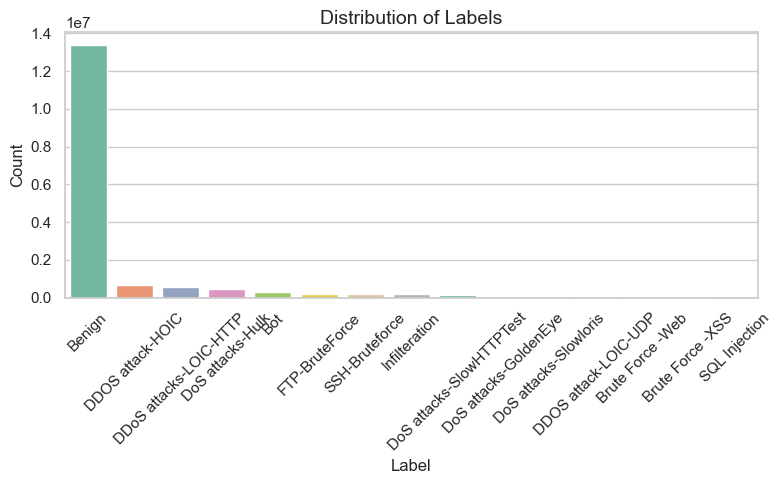

In [4]:
# Create a mapping of original attack labels to broader categories
import seaborn as sns
import matplotlib.pyplot as plt

mapping= {'SSH-Bruteforce': 'Brute-force',
          'FTP-BruteForce': 'Brute-force',
          ################ Brute-force 
          
          'Brute Force -XSS': 'Web attack',
          'Brute Force -Web': 'Web attack',
          'SQL Injection': 'Web attack',
          ################ Web attack 
          
          'DoS attacks-Hulk': 'DoS attack',
          'DoS attacks-SlowHTTPTest': 'DoS attack',
          'DoS attacks-Slowloris': 'DoS attack',
          'DoS attacks-GoldenEye': 'DoS attack',
          ################ DoS attack 
          
          'DDOS attack-HOIC': 'DDoS attack',
          'DDOS attack-LOIC-UDP': 'DDoS attack',
          'DDoS attacks-LOIC-HTTP': 'DDoS attack',
          ################ DDoS attack 
          
          'Bot': 'Botnet',
          ################ Botnet 
          
          'Infilteration': 'Infilteration',
          ################ Infilteration 
          
          'Benign': 'Benign',
          'Label': 'Benign',
          ################ Infilteration 
    }

def transform_multi_label(df):
    print(df['Label'].value_counts())
    
    # Set style for better visuals
    sns.set(style="whitegrid")

    # Plot class distribution
    plt.figure(figsize=(8, 5))
    sns.countplot(x='Label', data=df, order=df['Label'].value_counts().index, palette="Set2")

    plt.title('Distribution of Labels', fontsize=14)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print('\n')
    df['Label'] = df['Label'].map(mapping) 
    return df


data_preprocess = transform_multi_label(data_preprocess)

In [5]:
# Check the distribution of the labels after mapping
data_preprocess['Label'].value_counts()

Label
Benign           13390249
DDoS attack       1263933
DoS attack         654300
Brute-force        380943
Botnet             286191
Infilteration      160639
Web attack            928
Name: count, dtype: int64

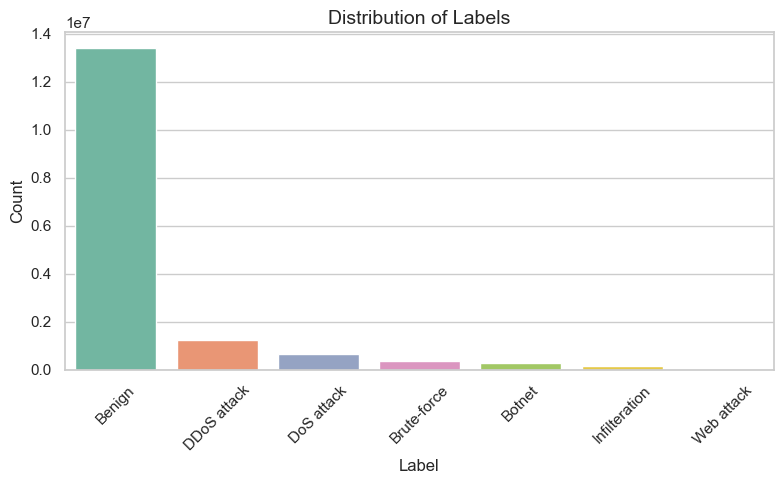

In [6]:

# Set style for better visuals
sns.set(style="whitegrid")

# Plot class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Label', data=data_preprocess, order=data_preprocess['Label'].value_counts().index, palette="Set2")

plt.title('Distribution of Labels', fontsize=14)
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Step 3: Filter Unwanted Classes and Balance the Dataset

- Before training, we remove low-representation or irrelevant categories like `Botnet`, `Infiltration`, and `Web attack`.  
- Then we use **random undersampling** to balance the remaining classes (`Benign`, `Brute-force`, `DDoS attack`, and `DoS attack`) to ensure the model is not biased toward the majority class.


In [7]:
# %pip install imbalanced-learn

from imblearn.under_sampling import RandomUnderSampler

def balance_data(df):
    X=df.drop(["Label"], axis=1)
    y=df["Label"]

    rus = RandomUnderSampler()
    X_balanced, y_balanced = rus.fit_resample(X, y) 

    df = pd.concat([X_balanced, y_balanced], axis=1)
    del X, y, X_balanced, y_balanced
    print (df.shape)
    print(df['Label'].value_counts())
    
    return df


# Drop rows with unwanted categories
unwanted_categories = ['Botnet', 'Infilteration', 'Web attack']
data_preprocess = data_preprocess[~data_preprocess['Label'].isin(unwanted_categories)]

data_preprocess1 = balance_data(data_preprocess)

(1523772, 79)
Label
Benign         380943
Brute-force    380943
DDoS attack    380943
DoS attack     380943
Name: count, dtype: int64


## Step 4: Remove Constant (Zero-Variance) Features

- This step removes features that have **zero variance** across all samples — i.e., their value is constant for every row in the dataset.  
- Such features do **not provide any useful information** for classification and can be safely dropped to reduce dimensionality and improve model performance.


In [8]:
variances = data_preprocess1.var(numeric_only=True)
constant_columns = variances[variances == 0].index
data_preprocess1 = data_preprocess1.drop(constant_columns, axis=1)

print("Columns that have constant values:",constant_columns)


Columns that have constant values: Index(['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg',
       'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg',
       'Bwd Blk Rate Avg'],
      dtype='object')


## Step 5: Detect and Remove Duplicate Columns

In this step, we identify and remove **duplicate columns** — i.e., columns that have identical values across all rows.  
We use a hashing technique to efficiently detect duplicates by:
- Hashing each column's content
- Grouping columns with the same hash
- Keeping only one copy and dropping the rest

This helps reduce redundancy and improves model efficiency.


In [9]:
import pandas as pd
import hashlib

def hash_series(s):
    return hashlib.md5(pd.util.hash_pandas_object(s, index=False).values).hexdigest()

# Hash all columns
col_hashes = {col: hash_series(data_preprocess1[col]) for col in data_preprocess1.columns}

# Invert the dict to find duplicates
from collections import defaultdict

hash_map = defaultdict(list)
for col, h in col_hashes.items():
    hash_map[h].append(col)

# Get all groups with duplicates
duplicate_cols = [cols[1:] for cols in hash_map.values() if len(cols) > 1]
duplicate_cols = [item for sublist in duplicate_cols for item in sublist]

print(f"Duplicate columns: {duplicate_cols}")

data_preprocess1 = data_preprocess1.drop(columns=duplicate_cols)


Duplicate columns: ['Subflow Fwd Pkts', 'Subflow Bwd Pkts', 'Subflow Fwd Byts', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'SYN Flag Cnt', 'CWE Flag Count']


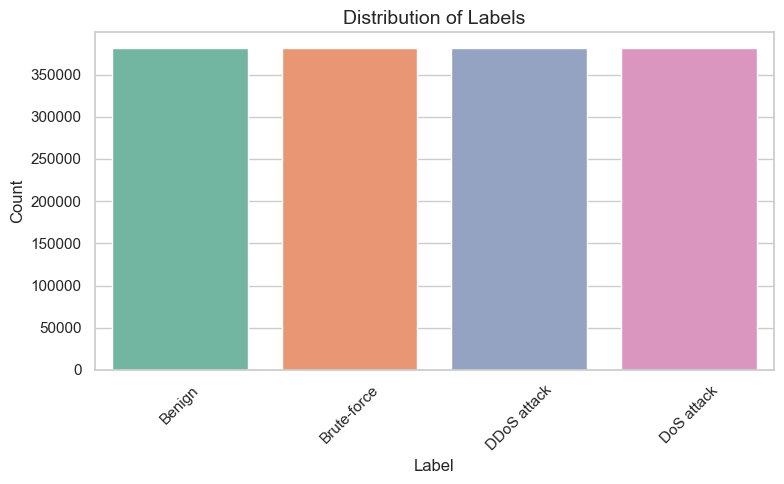

In [10]:
sns.set(style="whitegrid")

# Plot class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Label', data=data_preprocess1, order=data_preprocess1['Label'].value_counts().index, palette="Set2")

plt.title('Distribution of Labels', fontsize=14)
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


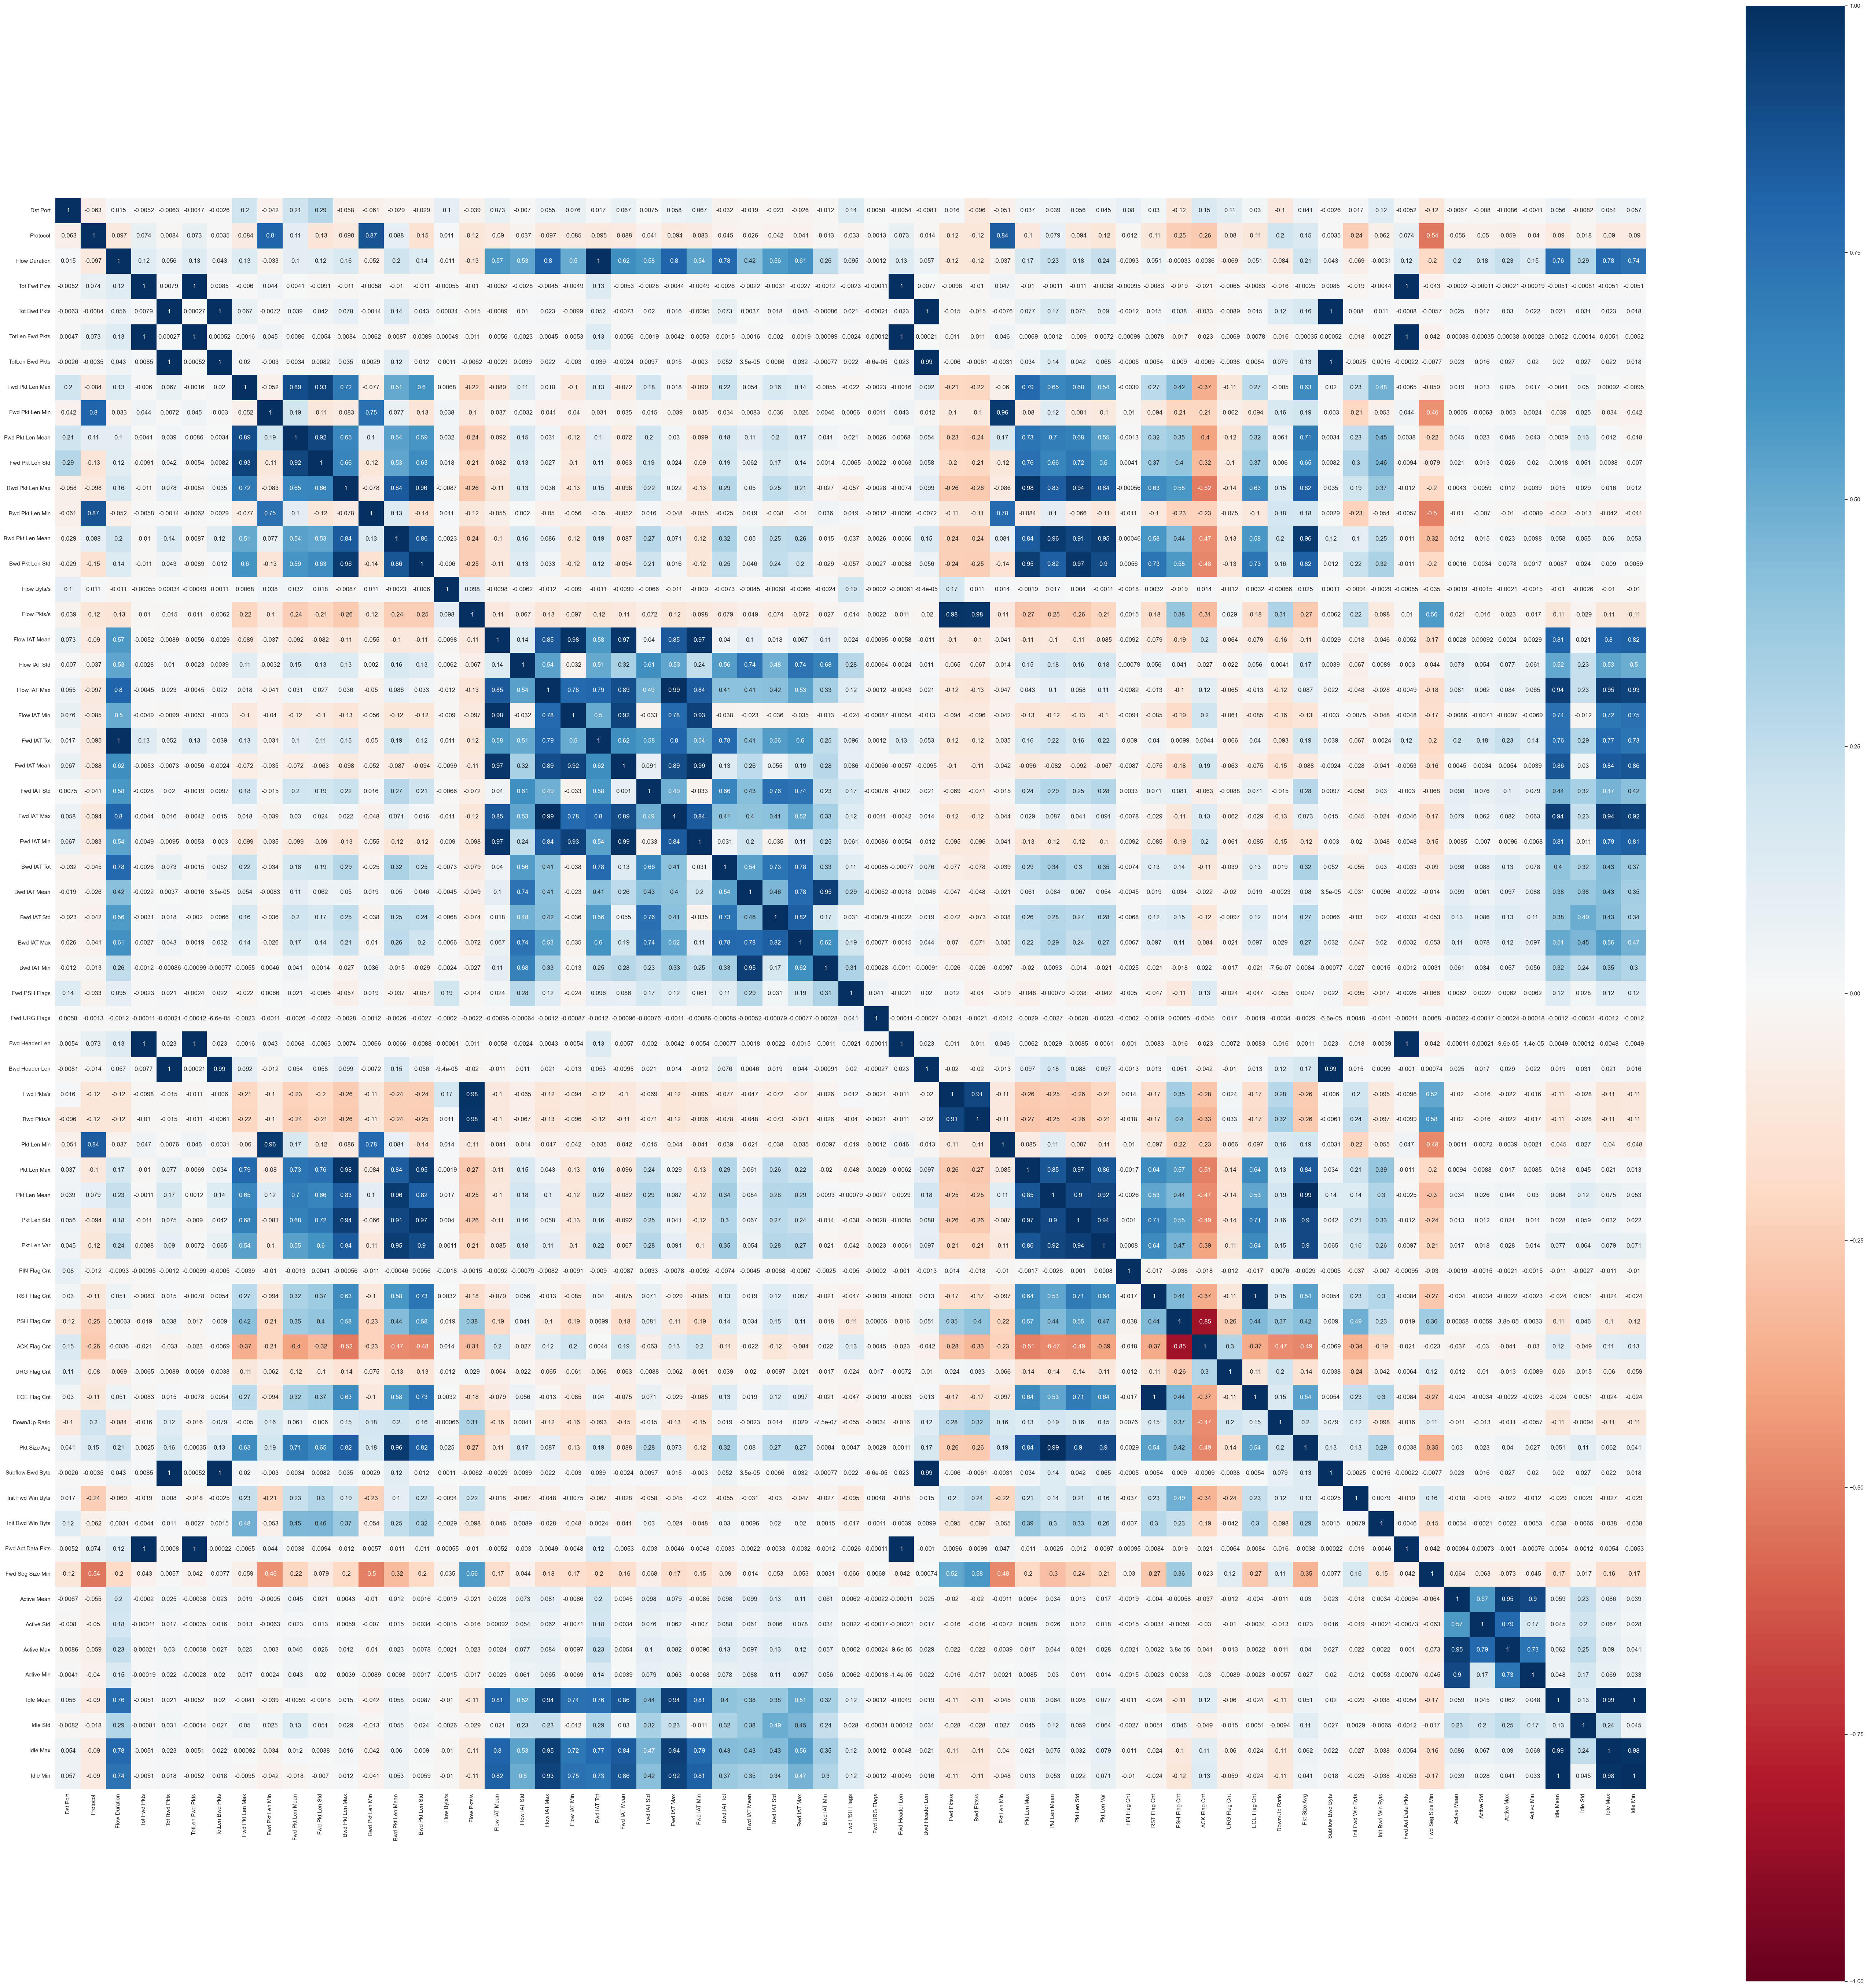

In [11]:
# pearson correlation heatmap
plt.figure(figsize=(70, 70))
corr = data_preprocess1.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='RdBu', vmin=-1, vmax=1, square=True) # annot=True
plt.show()

## Step 7: Remove Highly Correlated Features

To reduce multicollinearity and improve model efficiency, we remove features that are **highly correlated** with others.  
In this step, we:
- Compute the correlation matrix
- Remove one feature from each pair of features with a correlation above `0.92`  
This ensures that redundant information is eliminated, improving model generalization.


In [12]:
import numpy as np
correlated_col = set()
is_correlated = [True] * len(corr.columns)
threshold = 0.92
for i in range (len(corr.columns)):
    if(is_correlated[i]):
        for j in range(i):
            if (np.abs(corr.iloc[i, j]) >= threshold) and (is_correlated[j]):
                colname = corr.columns[j]
                is_correlated[j]=False
                correlated_col.add(colname)

print("Correlated Columns:",correlated_col)
print("Count of Correlated Columns:",len(correlated_col))

Correlated Columns: {'Active Mean', 'Tot Bwd Pkts', 'Idle Mean', 'TotLen Fwd Pkts', 'Flow Pkts/s', 'Pkt Len Max', 'Fwd IAT Mean', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Fwd Pkt Len Min', 'Pkt Len Mean', 'Idle Max', 'Flow Duration', 'Bwd Pkt Len Mean', 'Flow IAT Max', 'Bwd Pkt Len Max', 'RST Flag Cnt', 'TotLen Bwd Pkts', 'Tot Fwd Pkts', 'Pkt Len Std', 'Fwd IAT Max', 'Flow IAT Min', 'Bwd Header Len', 'Fwd Header Len', 'Bwd IAT Mean', 'Flow IAT Mean'}
Count of Correlated Columns: 27


In [13]:
# Drop the correlated columns

data_preprocess1.drop(correlated_col, axis=1, inplace=True)
print ("Shape after dropping correlated columns:",data_preprocess1.shape)

Shape after dropping correlated columns: (1523772, 37)


## Step 8: Train Test Split


In [14]:
label_col = 'Label'
feature_cols = list(data_preprocess1.columns)
feature_cols.remove(label_col)

In [15]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(data_preprocess1, test_size=0.2, random_state=2, shuffle=True, stratify=data_preprocess1[label_col])

del data_preprocess1 

## Step 9: Feature Scaling and Label Encoding

In this step, we:
- Apply **MinMax scaling** to normalize feature values between 0 and 1 for better model performance.
- Encode the target labels (`Benign`, `Brute-force`, etc.) into integer values using a consistent label list.
- Export the processed training and testing datasets into CSV files for modeling.


In [16]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler

minmax_scaler = MinMaxScaler()
train_df[feature_cols] = minmax_scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols] = minmax_scaler.transform(test_df[feature_cols])

In [17]:
order_label_list = list(np.unique(train_df[label_col]))
order_label_list

['Benign', 'Brute-force', 'DDoS attack', 'DoS attack']

# Phase 2: Modeling

In this phase, we build and evaluate three different classifiers for the Intrusion Detection task:

1. **Decision Tree Classifier**
   - A simple, interpretable model based on tree splits.
   - Useful for understanding feature importance and baseline performance.

### Evaluation Metrics
Each model is evaluated using:
- **Classification Report** (precision, recall, F1-score)
- **Confusion Matrix** (visualized using Seaborn heatmap)
- **Overall Accuracy**

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     76189
           1       0.90      0.89      0.90     76189
           2       0.98      1.00      0.99     76188
           3       0.89      0.90      0.90     76189

    accuracy                           0.94    304755
   macro avg       0.94      0.94      0.94    304755
weighted avg       0.94      0.94      0.94    304755



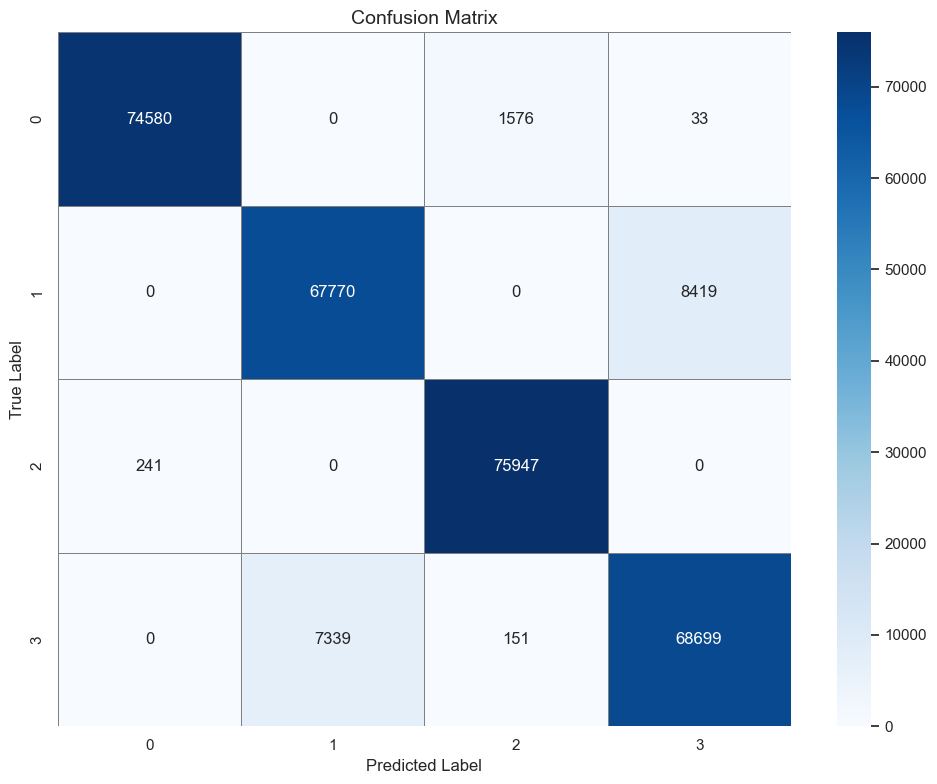

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier


X_train = train_df[feature_cols]
X_test = test_df[feature_cols]

y_train = [order_label_list.index(k) for k in train_df[label_col]]
y_test = [order_label_list.index(k) for k in test_df[label_col]]

dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train.values, y_train)    

y_pred = dt.predict(X_test.values)
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)

sns.set_style("whitegrid") 

# Plot heatmap
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt=".0f",
    linewidths=0.5,
    linecolor="gray",
    cmap="Blues", 
    ax=ax
)

# Add labels and title
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.tight_layout()
plt.show()

2. **Random Forest Classifier**
   - An ensemble of decision trees that improves accuracy and reduces overfitting.
   - Robust to noise and effective on high-dimensional data.

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     76189
           1       0.82      1.00      0.90     76189
           2       0.98      1.00      0.99     76188
           3       1.00      0.78      0.88     76189

    accuracy                           0.94    304755
   macro avg       0.95      0.94      0.94    304755
weighted avg       0.95      0.94      0.94    304755



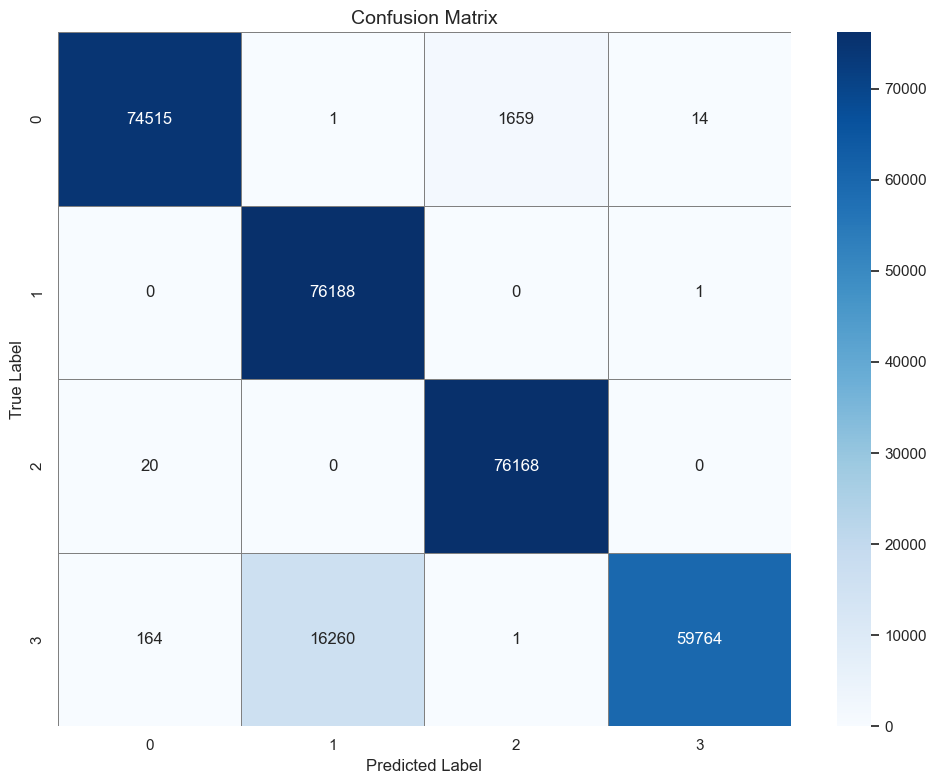

In [21]:

rf = RandomForestClassifier(max_depth=5)
rf.fit(X_train.values, y_train)    
y_pred = rf.predict(X_test.values)
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)

sns.set_style("whitegrid") 

# Plot heatmap
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt=".0f",
    linewidths=0.5,
    linecolor="gray",
    cmap="Blues", 
    ax=ax
)

# Add labels and title
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.tight_layout()
plt.show()

3. **XGBoost Classifier**
   - A gradient boosting algorithm known for speed and high performance.
   - Handles class imbalance well and supports regularization for better generalization.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     76189
           1       0.89      0.96      0.92     76189
           2       1.00      1.00      1.00     76188
           3       0.96      0.88      0.92     76189

    accuracy                           0.96    304755
   macro avg       0.96      0.96      0.96    304755
weighted avg       0.96      0.96      0.96    304755



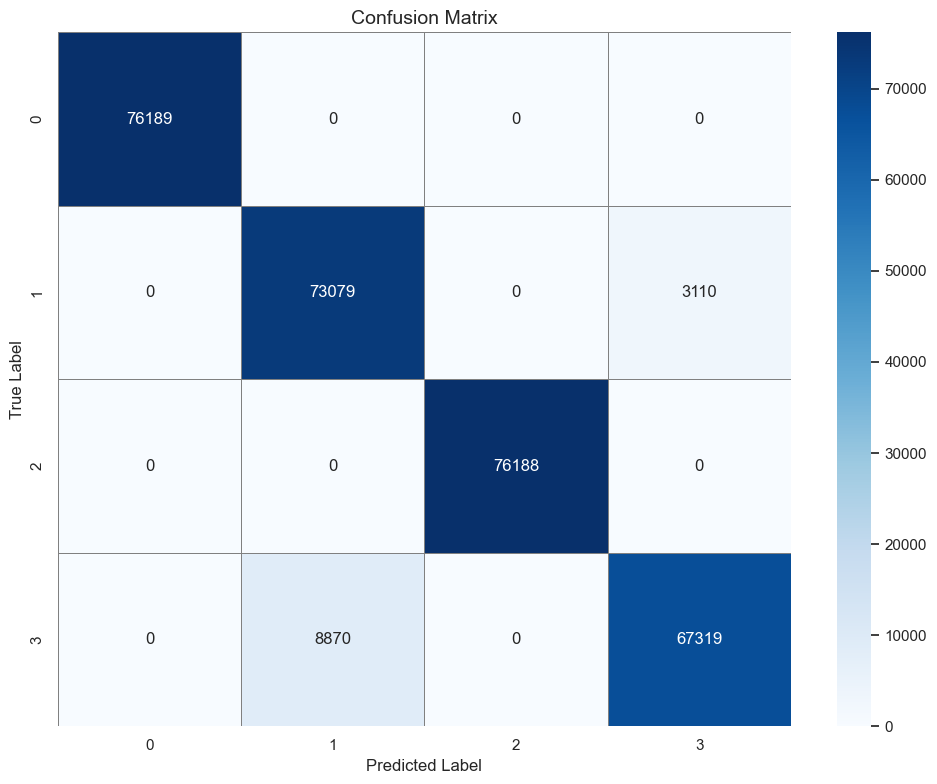

In [22]:
# ! brew install libomp
# ! python3 -m pip install xgboost

from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=100)
model.fit(X_train.values, y_train)    
y_pred = model.predict(X_test.values)
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)

sns.set_style("whitegrid") 

# Plot heatmap
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt=".0f",
    linewidths=0.5,
    linecolor="gray",
    cmap="Blues", 
    ax=ax
)

# Add labels and title
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.tight_layout()
plt.show()

## Feature Importance using Random Forest

We use a trained **Random Forest Classifier** to evaluate the importance of each feature.  
This allows us to:
- Identify the most influential features in intrusion detection
- Optionally reduce dimensionality by selecting only top-ranked features

The table below shows the features sorted by their importance scores, helping guide feature selection and model refinement.


In [24]:
ext=pd.DataFrame(rf.feature_importances_,columns=["extratrees_importance"])
ext = ext.sort_values(['extratrees_importance'], ascending=False)
feature_cols = X_train.columns
feature_index = [feature_cols[i] for i in list(ext.index)]
ext["Feature_Name"] = feature_index
ext

,extratrees_importance,Feature_Name
30,1.900578e-01,Fwd Seg Size Min
0,1.611680e-01,Dst Port
27,1.156069e-01,Init Fwd Win Byts
16,6.323736e-02,Bwd Pkts/s
15,5.933775e-02,Fwd Pkts/s
6,5.583783e-02,Fwd IAT Tot
8,4.760825e-02,Fwd IAT Min
28,4.555107e-02,Init Bwd Win Byts
25,3.121082e-02,Pkt Size Avg
7,2.759846e-02,Fwd IAT Std


In [25]:
from sklearn.feature_selection import SelectFromModel

# Used the fitted model to select features
selector = SelectFromModel(model, prefit=False)  
selector.fit(X_train, y_train)  

selected_features = list(selector.get_feature_names_out(input_features=feature_cols))
print(selected_features)

['Dst Port', 'Fwd IAT Std', 'Bwd IAT Std', 'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Seg Size Min']


### Decision Tree Classifier

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     76189
           1       0.82      1.00      0.90     76189
           2       0.96      1.00      0.98     76188
           3       1.00      0.78      0.88     76189

    accuracy                           0.94    304755
   macro avg       0.95      0.94      0.94    304755
weighted avg       0.95      0.94      0.94    304755



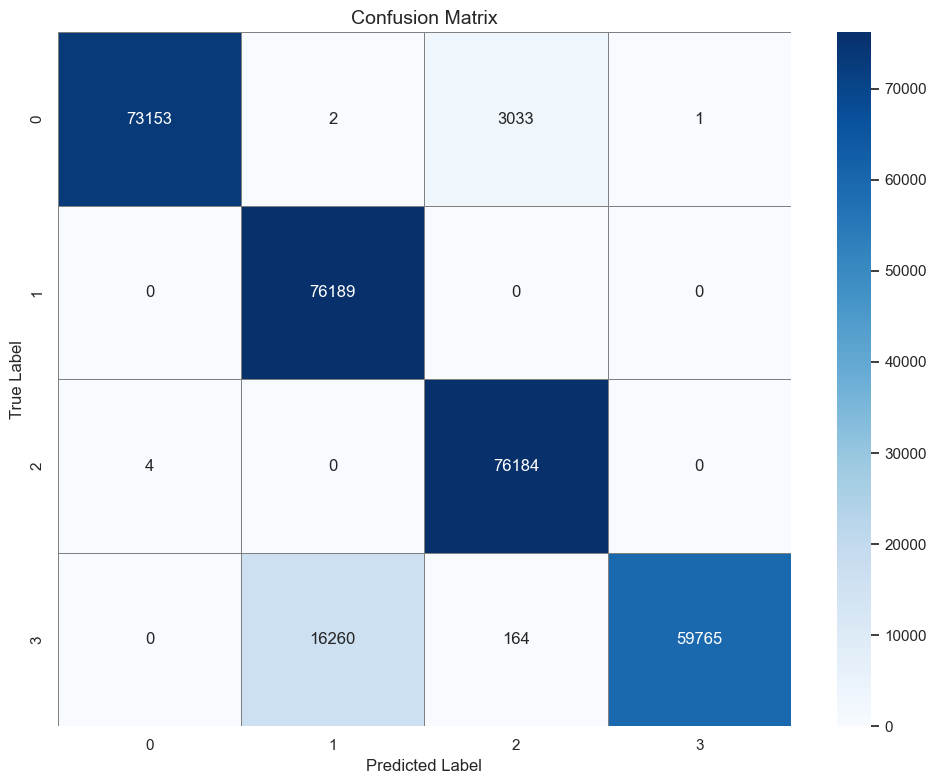

In [26]:
#Decision Tree

dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train[selected_features].values, y_train)    

y_pred = dt.predict(X_test[selected_features].values)
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)

sns.set_style("whitegrid") 

# Plot heatmap
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt=".0f",
    linewidths=0.5,
    linecolor="gray",
    cmap="Blues", 
    ax=ax
)

# Add labels and title
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.tight_layout()
plt.show()

### Random Forest Classifier

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     76189
           1       0.82      1.00      0.90     76189
           2       0.96      0.99      0.97     76188
           3       1.00      0.78      0.88     76189

    accuracy                           0.93    304755
   macro avg       0.94      0.93      0.93    304755
weighted avg       0.94      0.93      0.93    304755



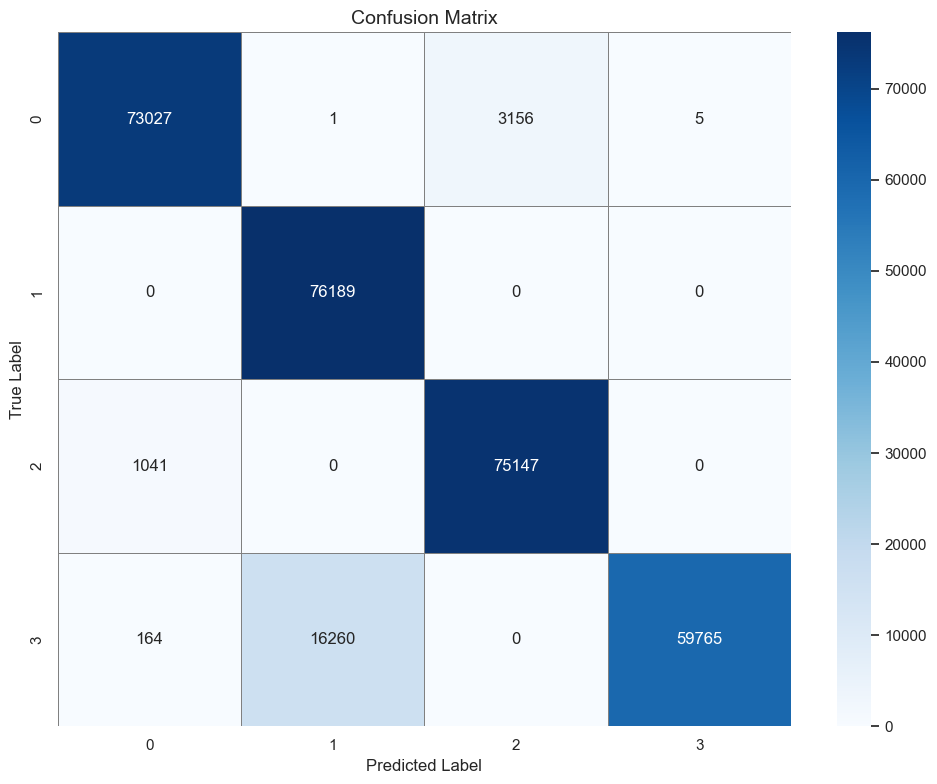

In [27]:
rf = RandomForestClassifier(max_depth=5)
rf.fit(X_train[selected_features].values, y_train)    

y_pred = rf.predict(X_test[selected_features].values)
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)

sns.set_style("whitegrid") 

# Plot heatmap
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt=".0f",
    linewidths=0.5,
    linecolor="gray",
    cmap="Blues", 
    ax=ax
)

# Add labels and title
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.tight_layout()
plt.show()

### XGBoost Classifier

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     76189
           1       0.82      1.00      0.90     76189
           2       1.00      1.00      1.00     76188
           3       1.00      0.79      0.88     76189

    accuracy                           0.95    304755
   macro avg       0.96      0.95      0.95    304755
weighted avg       0.96      0.95      0.95    304755



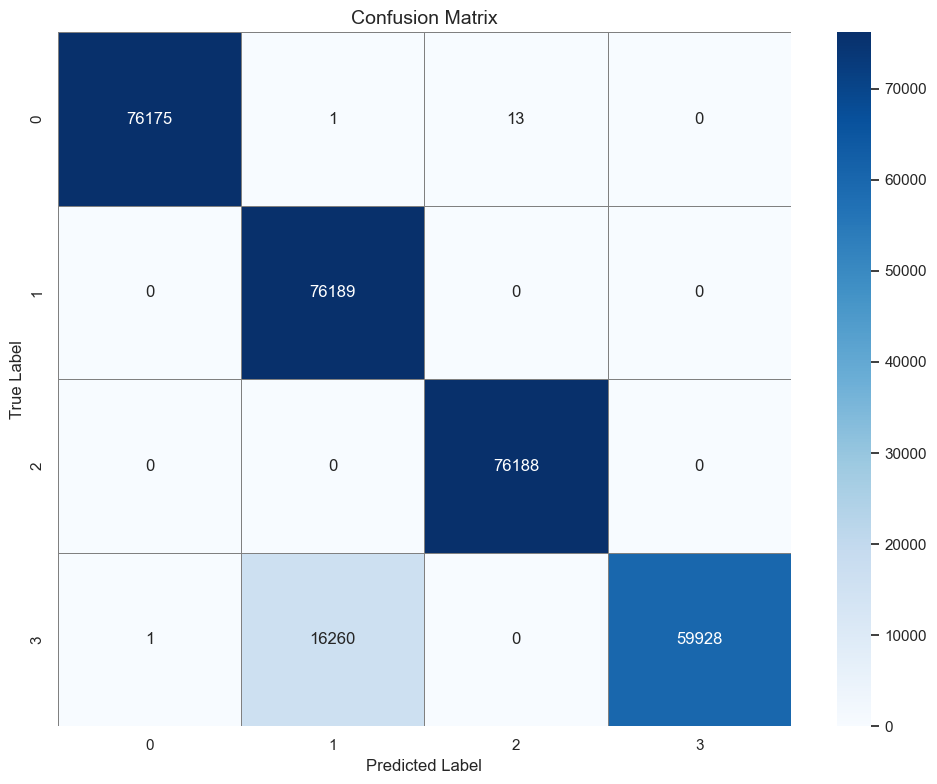

In [28]:
model = XGBClassifier(n_estimators=100)
model.fit(X_train[selected_features].values, y_train)    
y_pred = model.predict(X_test[selected_features].values)
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)

sns.set_style("whitegrid") 

# Plot heatmap
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt=".0f",
    linewidths=0.5,
    linecolor="gray",
    cmap="Blues", 
    ax=ax
)

# Add labels and title
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.tight_layout()
plt.show()

### Observation: No Significant Change After Feature Selection

After re-training all models (Decision Tree, Random Forest, XGBoost) using only the most important features,  
we observed that the classification metrics (accuracy, precision, recall, F1-score) remained largely **unchanged**.

### Interpretation:
- The top features captured most of the predictive power.
- The removed features likely had little or no impact on the model’s decisions.
- This confirms that the model was already robust and not overfitting to irrelevant features.

This step validates the feature selection process and suggests the model is both efficient and stable.
